In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
df = pd.read_csv('/Volumes/transcend/大檔案/中華郵政/雙北市ACC價錢.csv')

/Users/andy/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
df = df[['局名','ACC01','ACC06','ACC13','ACC14','ACC15']]
df.head(2)

,局名,ACC01,ACC06,ACC13,ACC14,ACC15
0,臺北大安,100117,1070102,1,1,1
1,臺北大安,100117,1070102,1,3,1


### 計算各郵局每天案件量

In [3]:
df_time = df.groupby(['局名','ACC06'])['ACC13'].sum().reset_index()
df_time.head(3)

,局名,ACC06,ACC13
0,三峽,1070102,30645
1,三峽,1070103,7074
2,三峽,1070104,3894


### 預測新店郵局

In [416]:
import warnings
warnings.filterwarnings("ignore")
df_target = df_time[df_time['局名']=='新店']
# 抽出星期
df_target['ACC06'] = df_target['ACC06'].astype(str).str.replace('107','2018')
# df_target['ACC06'] = df_target['ACC06'].astype(str).str.replace('201802018','20180107')
df_target['ACC06'] = pd.to_datetime(df_target['ACC06'], format='%Y%m%d')
df_target['weekday'] = df_target['ACC06'].dt.weekday
df_target = df_target.drop('局名',axis=1)
df_target = df_target.drop('ACC06',axis=1)

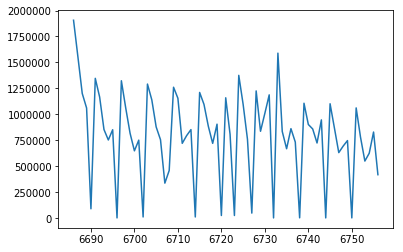

In [417]:
import matplotlib.pyplot as plt
plt.plot(df_target['ACC13'])
plt.show()

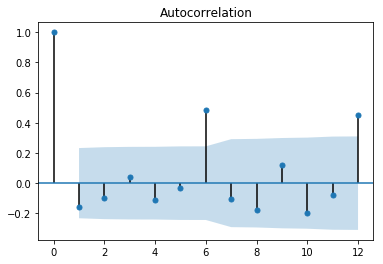

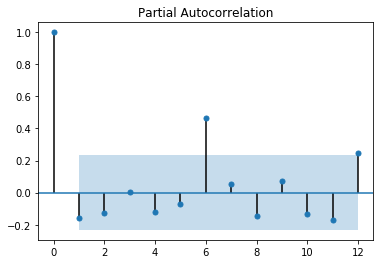

In [40]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
# 畫出 ACF 12 期的效應
sm.graphics.tsa.plot_acf(df_target['ACC13'], lags=12)
plt.show()
# 畫出 PACF 12 期的效應
sm.graphics.tsa.plot_pacf(df_target['ACC13'], lags=12)
plt.show()

In [418]:
# 正規化(normalize) 資料，使資料值介於[0, 1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_target_sca = df_target.copy()
df_target_sca['ACC13'] = scaler.fit_transform(pd.DataFrame(df_target['ACC13']))

In [419]:
# 2/3 資料為訓練資料， 1/3 資料為測試資料
train_size = int(len(df_target_sca) * 0.67)
test_size = len(df_target_sca) - train_size
train, test = df_target_sca.values[0:train_size,:], df_target_sca.values[train_size:len(df_target_sca),:]

In [420]:
trainX = df_target_sca.values[0:train_size,:]
trainY = df_target_sca.values[1:train_size+1,0]
testX = df_target_sca.values[train_size:len(df_target_sca),:]
testY = df_target_sca.values[train_size+1:len(df_target_sca),0]

trainX = np.expand_dims(trainX, axis=1)
testX = np.expand_dims(testX, axis=1)

In [235]:
# 產生 (X, Y) 資料集, Y 是下一期的乘客數
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# 產生 (X, Y) 資料集, Y 是下一期的乘客數(reshape into X=t and Y=t+1)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### LSTM

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [421]:
# 建立及訓練 LSTM 模型
model = Sequential()
model.add(LSTM(32, input_shape=(1, 2)))
model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=32,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [422]:
# 預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [423]:
# calculate 均方根誤差(root mean squared error)
import math
from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:-1,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.09 RMSE
Test Score: 0.09 RMSE


In [424]:
# 回復預測資料值為原始數據的規模
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [425]:
# 回復後
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:-1,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 164882.19 RMSE
Test Score: 174778.31 RMSE


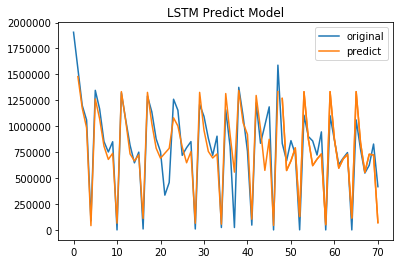

In [463]:
# 畫訓練資料趨勢圖
trainPredictPlot = np.empty_like(df_target_sca)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict

# 畫測試資料趨勢圖
testPredictPlot = np.empty_like(df_target_sca)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+1:len(df_target_sca), :] = testPredict[0:-1]

# 畫原始資料趨勢圖
plt.plot(scaler.inverse_transform(pd.DataFrame(df_target_sca['ACC13'])), label='original')
plt.plot(trainPredictPlot[:,0], 'C1', label='predict')
plt.plot(testPredictPlot, 'C1')
plt.title('LSTM Predict Model')
plt.legend(loc='upper right')
plt.show()

### 預測細分類

In [169]:
df_acc15 = df.groupby(['局名','ACC06','ACC14','ACC15'])['ACC13'].sum().reset_index()

In [360]:
# 預測小包
df_target = df_acc15[(df_acc15['ACC14']==1)&(df_acc15['ACC15']==2)]
df_target = df_target[df_target['局名']=='新店']
df_target['ACC06'] = df_target['ACC06'].astype(str).str.replace('107','2018')
df_target['ACC06'] = pd.to_datetime(df_target['ACC06'], format='%Y%m%d')
df_target['weekday'] = df_target['ACC06'].dt.weekday
df_target = df_target.drop('局名',axis=1)
df_target = df_target.drop('ACC06',axis=1)
df_target = df_target.drop('ACC14',axis=1)
df_target = df_target.drop('ACC15',axis=1)

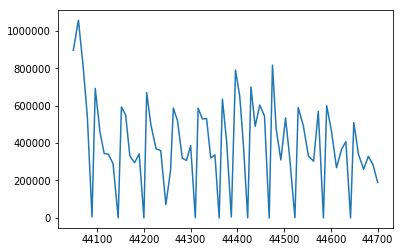

In [361]:
import matplotlib.pyplot as plt
plt.plot(df_target['ACC13'])
plt.show()

In [362]:
# 正規化(normalize) 資料，使資料值介於[0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
df_target_sca = df_target.copy()
df_target_sca['ACC13'] = scaler.fit_transform(pd.DataFrame(df_target['ACC13']))
# 2/3 資料為訓練資料， 1/3 資料為測試資料
train_size = int(len(df_target_sca) * 0.67)
test_size = len(df_target_sca) - train_size
trainX = df_target_sca.values[0:train_size,:]
trainY = df_target_sca.values[1:train_size+1,0]
testX = df_target_sca.values[train_size:len(df_target_sca),:]
testY = df_target_sca.values[train_size+1:len(df_target_sca),0]

trainX = np.expand_dims(trainX, axis=1)
testX = np.expand_dims(testX, axis=1)

In [363]:
# 建立及訓練 LSTM 模型
model = Sequential()
model.add(LSTM(16, input_shape=(1, 2)))
model.add(Dense(units=32,activation='relu'))
model.add(Dense(units=16,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.1188
Epoch 2/100
 - 0s - loss: 0.0759
Epoch 3/100
 - 0s - loss: 0.0668
Epoch 4/100
 - 0s - loss: 0.0612
Epoch 5/100
 - 0s - loss: 0.0571
Epoch 6/100
 - 0s - loss: 0.0574
Epoch 7/100
 - 0s - loss: 0.0539
Epoch 8/100
 - 0s - loss: 0.0535
Epoch 9/100
 - 0s - loss: 0.0527
Epoch 10/100
 - 0s - loss: 0.0524
Epoch 11/100
 - 0s - loss: 0.0522
Epoch 12/100
 - 0s - loss: 0.0507
Epoch 13/100
 - 0s - loss: 0.0507
Epoch 14/100
 - 0s - loss: 0.0501
Epoch 15/100
 - 0s - loss: 0.0494
Epoch 16/100
 - 0s - loss: 0.0485
Epoch 17/100
 - 0s - loss: 0.0470
Epoch 18/100
 - 0s - loss: 0.0483
Epoch 19/100
 - 0s - loss: 0.0472
Epoch 20/100
 - 0s - loss: 0.0463
Epoch 21/100
 - 0s - loss: 0.0438
Epoch 22/100
 - 0s - loss: 0.0436
Epoch 23/100
 - 0s - loss: 0.0425
Epoch 24/100
 - 0s - loss: 0.0405
Epoch 25/100
 - 0s - loss: 0.0387
Epoch 26/100
 - 0s - loss: 0.0367
Epoch 27/100
 - 0s - loss: 0.0350
Epoch 28/100
 - 0s - loss: 0.0320
Epoch 29/100
 - 0s - loss: 0.0324
Epoch 30/100
 - 0s - lo

In [364]:
# 預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# calculate 均方根誤差(root mean squared error)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:-1,0]))
print('Test Score: %.2f RMSE' % (testScore))
# 回復預測資料值為原始數據的規模
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# 回復後
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:-1,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.11 RMSE
Test Score: 0.10 RMSE
Train Score: 113674.67 RMSE
Test Score: 108979.62 RMSE


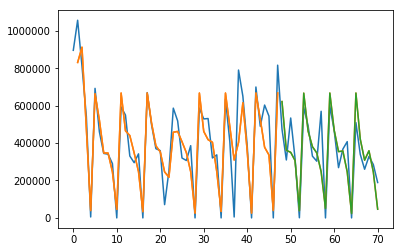

In [365]:
# 畫訓練資料趨勢圖
trainPredictPlot = np.empty_like(df_target_sca)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict

# 畫測試資料趨勢圖
testPredictPlot = np.empty_like(df_target_sca)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+1:len(df_target_sca), :] = testPredict[0:-1]

# 畫原始資料趨勢圖
plt.plot(scaler.inverse_transform(pd.DataFrame(df_target_sca['ACC13'])))
plt.plot(trainPredictPlot, 'C1')
plt.plot(testPredictPlot)
plt.show()

In [366]:
# 預測雜誌
df_target = df_acc15[(df_acc15['ACC14']==1)&(df_acc15['ACC15']==3)]
df_target = df_target[df_target['局名']=='新店']

# 會有日期是空的，補0
df_xindian = df_time[df_time['局名']=='新店']
df_xindian = df_xindian[['局名','ACC06']]
df_target = pd.merge(df_xindian, df_target, how='left', on='ACC06')
df_target = df_target[['ACC06', 'ACC13']]
df_target['ACC13'] = df_target['ACC13'].fillna(0)
df_target['ACC06'] = df_target['ACC06'].astype(str).str.replace('107','2018')
df_target['ACC06'] = pd.to_datetime(df_target['ACC06'], format='%Y%m%d')
df_target['weekday'] = df_target['ACC06'].dt.weekday
df_target = df_target.drop('ACC06',axis=1)

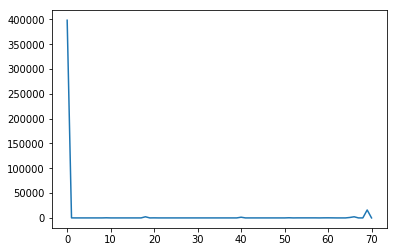

In [367]:
plt.plot(df_target['ACC13'])
plt.show()

In [368]:
# 正規化(normalize) 資料，使資料值介於[0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
df_target_sca = df_target.copy()
df_target_sca['ACC13'] = scaler.fit_transform(pd.DataFrame(df_target['ACC13']))
# 2/3 資料為訓練資料， 1/3 資料為測試資料
train_size = int(len(df_target_sca) * 0.67)
test_size = len(df_target_sca) - train_size
trainX = df_target_sca.values[0:train_size,:]
trainY = df_target_sca.values[1:train_size+1,0]
testX = df_target_sca.values[train_size:len(df_target_sca),:]
testY = df_target_sca.values[train_size+1:len(df_target_sca),0]

trainX = np.expand_dims(trainX, axis=1)
testX = np.expand_dims(testX, axis=1)

In [370]:
# 建立及訓練 LSTM 模型
model = Sequential()
model.add(LSTM(16, input_shape=(1, 2)))
model.add(Dense(units=32,activation='relu'))
model.add(Dense(units=16,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [371]:
# 預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# calculate 均方根誤差(root mean squared error)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:-1,0]))
print('Test Score: %.2f RMSE' % (testScore))
# 回復預測資料值為原始數據的規模
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# 回復後
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:-1,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.00 RMSE
Test Score: 0.01 RMSE
Train Score: 434.63 RMSE
Test Score: 3348.41 RMSE


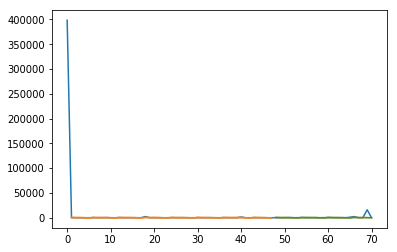

In [372]:
# 畫訓練資料趨勢圖
trainPredictPlot = np.empty_like(df_target_sca)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict

# 畫測試資料趨勢圖
testPredictPlot = np.empty_like(df_target_sca)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+1:len(df_target_sca), :] = testPredict[0:-1]

# 畫原始資料趨勢圖
plt.plot(scaler.inverse_transform(pd.DataFrame(df_target_sca['ACC13'])))
plt.plot(trainPredictPlot, 'C1')
plt.plot(testPredictPlot)
plt.show()

### 預測新店全部細項

In [378]:
df_xindian_all = df_temp.groupby(['ACC14','ACC15'])['ACC13'].sum().reset_index()
df_xindian_all

,ACC14,ACC15,ACC13
0,1,1,618325
1,1,2,28163730
2,1,3,422806
3,1,4,7252
4,1,5,6020787
5,1,6,61514
6,1,7,602587
7,2,1,21000537
8,3,1,4715
9,3,2,358


In [174]:
# 最後一天3/31
df_temp = df_acc15[df_acc15['局名']=='新店']
df_temp[df_temp['ACC06']==1070331]

,局名,ACC06,ACC14,ACC15,ACC13
44699,新店,1070331,1,1,5297
44700,新店,1070331,1,2,189204
44701,新店,1070331,1,5,54571
44702,新店,1070331,1,6,46
44703,新店,1070331,2,1,168108
44704,新店,1070331,3,1,15
44705,新店,1070331,3,2,6
44706,新店,1070331,3,3,6


In [410]:
%time
for i,k in list(zip(df_xindian_all['ACC14'],df_xindian_all['ACC15'])):
    # 預測細項
    df_target = df_acc15[(df_acc15['ACC14']==i)&(df_acc15['ACC15']==k)]
    df_target = df_target[df_target['局名']=='新店']
    
    # 會有日期是空的，補0
    df_xindian = df_time[df_time['局名']=='新店']
    df_xindian = df_xindian[['局名','ACC06']]
    df_target = pd.merge(df_xindian, df_target, how='left', on='ACC06')
    df_target = df_target[['ACC06', 'ACC13']]
    df_target['ACC13'] = df_target['ACC13'].fillna(0)
    df_target['ACC06'] = df_target['ACC06'].astype(str).str.replace('107','2018')
    df_target['ACC06'] = pd.to_datetime(df_target['ACC06'], format='%Y%m%d')
    df_target['weekday'] = df_target['ACC06'].dt.weekday
    df_target = df_target.drop('ACC06',axis=1)
    
    # 正規化(normalize) 資料，使資料值介於[0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_target_sca = df_target.copy()
    df_target_sca['ACC13'] = scaler.fit_transform(pd.DataFrame(df_target['ACC13']))
    
    # 2/3 資料為訓練資料， 1/3 資料為測試資料
    train_size = int(len(df_target_sca) * 0.67)
    test_size = len(df_target_sca) - train_size
    trainX = df_target_sca.values[0:train_size,:]
    trainY = df_target_sca.values[1:train_size+1,0]
    testX = df_target_sca.values[train_size:len(df_target_sca),:]
    testY = df_target_sca.values[train_size+1:len(df_target_sca),0]
    trainX = np.expand_dims(trainX, axis=1)
    testX = np.expand_dims(testX, axis=1)
    
    # 建立及訓練 LSTM 模型
    model = Sequential()
    model.add(LSTM(32, input_shape=(1, 2)))
    model.add(Dense(units=64,activation='relu'))
    model.add(Dense(units=32,activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
    
    # 預測
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # 回復預測資料值為原始數據的規模
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    if testPredict[-1][0] < 0:
        testPredict[-1][0] = 0
    print('ACC14:',str(i),",",'ACC15:',str(k),",",'預測:',testPredict[-1][0])
print('Finish')

ACC14: 1 , ACC15: 1 , 預測: 2359.6082
ACC14: 1 , ACC15: 2 , 預測: 513431.03
ACC14: 1 , ACC15: 3 , 預測: 0.0
ACC14: 1 , ACC15: 4 , 預測: 76.65432
ACC14: 1 , ACC15: 5 , 預測: 134060.62
ACC14: 1 , ACC15: 6 , 預測: 2.7140498
ACC14: 1 , ACC15: 7 , 預測: 7956.6455
ACC14: 2 , ACC15: 1 , 預測: 477401.44
ACC14: 3 , ACC15: 1 , 預測: 42.124725
ACC14: 3 , ACC15: 2 , 預測: 2.4698036
ACC14: 3 , ACC15: 3 , 預測: 33.969418


In [414]:
a = ['新店郵局','新店郵局','新店郵局','新店郵局','新店郵局','新店郵局','新店郵局','新店郵局','新店郵局','新店郵局','新店郵局']
b = ['信函','小包','雜誌','新聞紙','印刷物','明信片','郵簡','一般包裹','一般快捷','文件快捷','商品快捷']
c = [5297,189204,0,0,54571,46,0,168108,15,6,6]
d = [2360,513431,0,77,134061,3,7957,477401,42,2,34]
df2 = pd.DataFrame(pd.DataFrame(list(zip(a,b,c,d)), columns=['郵局','ACC15','3/31件數','預測4/2件數']))
df2

,郵局,ACC15,3/31件數,預測4/2件數
0,新店郵局,信函,5297,2360
1,新店郵局,小包,189204,513431
2,新店郵局,雜誌,0,0
3,新店郵局,新聞紙,0,77
4,新店郵局,印刷物,54571,134061
5,新店郵局,明信片,46,3
6,新店郵局,郵簡,0,7957
7,新店郵局,一般包裹,168108,477401
8,新店郵局,一般快捷,15,42
9,新店郵局,文件快捷,6,2
